In [1]:
library(tidyverse)
library(magrittr)
library(pheatmap)

theme_set(theme_bw() + theme())

Warning message:
“package ‘tibble’ was built under R version 4.3.2”
Warning message:
“package ‘readr’ was built under R version 4.3.2”
Warning message:
“package ‘forcats’ was built under R version 4.3.2”
Warning message:
“package ‘lubridate’ was built under R version 4.3.2”
── Attaching core tidyverse packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts 

In [2]:
data_Abx <- readxl::read_xlsx(here::here("data", "microarray", "microarray_Abx.xlsx"))
data_Abx_ann <- readxl::read_xlsx(here::here("data", "microarray", "microarray_Abx_ann.xlsx"))
ann <- data_Abx_ann %>% column_to_rownames("Sample_ID2") %>% t() %>% as.data.frame()

New names:
• `transcript_cluster_id` -> `transcript_cluster_id...1`
• `transcript_cluster_id` -> `transcript_cluster_id...9`


In [3]:
ann %<>% mutate(Time_d=as.numeric(`Time (d)`))

In [4]:
data_Abx %<>% select(-c(transcript_cluster_id...1:Group, transcript_cluster_id...9)) %>% 
    group_by(`Gene Symbol`) %>% summarize(across(everything(), mean)) %>% column_to_rownames("Gene Symbol")

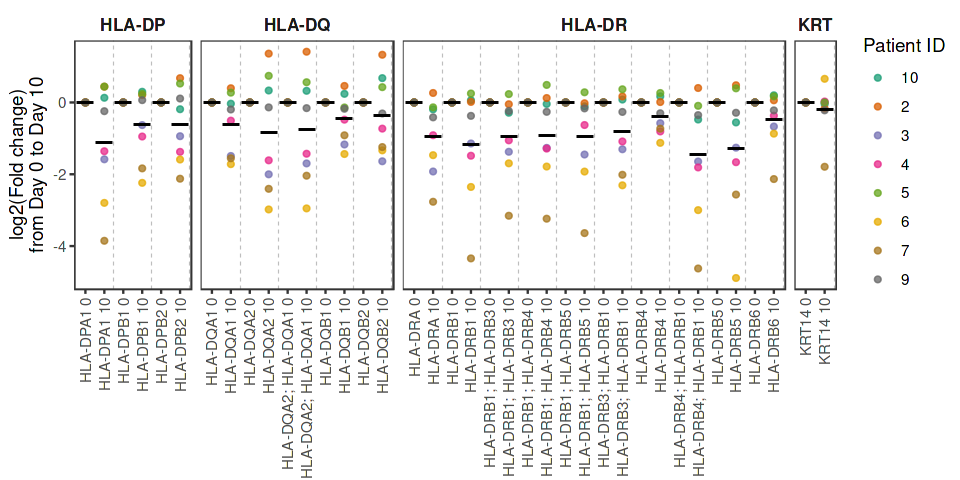

In [6]:
data_Abx %>% .[grep("HLA-D|KRT14$", rownames(.)), order(ann$`L/NL`, ann$Subject_ID, ann$`Time (d)`)] %>% rownames_to_column("gene") %>% 
    pivot_longer(-c(gene), names_to="sample", values_to="expression") %>% 
    mutate(group=gsub("^(HLA-D.).*$", "\\1", gene),
           group=gsub("^(KRT).*$", "\\1", group)) %>% 
    left_join(ann, by=c("sample"="Sample_ID")) %>% 
    filter(`L/NL` == "L" & Time_d <= 10) %>% 
    arrange(Time_d) %>% 
    group_by(gene, Subject_ID) %>% 
    filter(!group %in% c("HLA-DM", "HLA-DO")) %>% 
    mutate(expr_rel=(expression-expression[which(Time_d == 0)])) -> data_plot

plot <- data_plot %>% 
    ggplot(aes(y=expr_rel, x=paste(gene, Time_d))) +
        geom_point(aes(color=Subject_ID), size=1.25, alpha=0.75) + 
        stat_summary(fun=mean, geom="crossbar", width=0.9,
                   col="black", size=0.25) +
        geom_vline(xintercept=c(0.5+c(1:20)*2), linetype="dashed", color="grey", alpha=1, linewidth=0.25) + 
        facet_grid(cols=vars(group), scales="free", space="free_x") + 
        scale_color_brewer(palette = "Dark2") + 
        theme(axis.text.x=element_text(angle=90, hjust=1, vjust=0.5), strip.background=element_blank(), strip.text=element_text(face="bold", size=10),
              axis.title.x=element_blank(), panel.grid=element_blank()) + 
        labs(y="log2(Fold change)\nfrom Day 0 to Day 10", color="Patient ID")

options(repr.plot.width=8, repr.plot.height=4)
plot